In [535]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_style('darkgrid')
import matplotlib.ticker as ticker

import warnings; warnings.simplefilter('ignore')
from tqdm import tqdm_notebook as tqdm

import pyflux as pf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARMA
from pmdarima.arima import auto_arima

from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error as mse



### Problem 3. Simple forecasting

In [360]:
data = pd.read_csv('./BeerWineUS.csv')
data.head()

,DATE,MRTSSM4453USN
0,1992-01-01,1509
1,1992-02-01,1541
2,1992-03-01,1597
3,1992-04-01,1675
4,1992-05-01,1822


### Task 1. EWMA

> <font size=3>
    Exponential moving average is the simplest method for time series forecasting. The idea is simple we are trying to extract some general information from the signal (average) and then forecast initial signal with the value of the last average: <br><br>
    <center>$\hat{Y}_{t+1} = \alpha Y_t + (1 - \alpha)\hat{Y}_{t}$, where $\alpha \in (0, 1]$ </center><br>
    And we can compute forecast fot h steps ahead as follows: <br><br>
    <center>$\hat{Y}_{t+h} = \hat{Y}_{t+1}$ for each $h > 1$</center>
  <font>

In [249]:
# split data
ts = data.MRTSSM4453USN.values
train_ts, test_ts = ts[:200], ts[200:]

In [250]:
# let's look at ewma with alpha = 0.05
ewma = ExponentialSmoothing(train_ts, trend=None, seasonal=None)
ewma.fit(smoothing_level=0.5)
params = ewma.params
preds = ewma.predict(params, 0, 310)

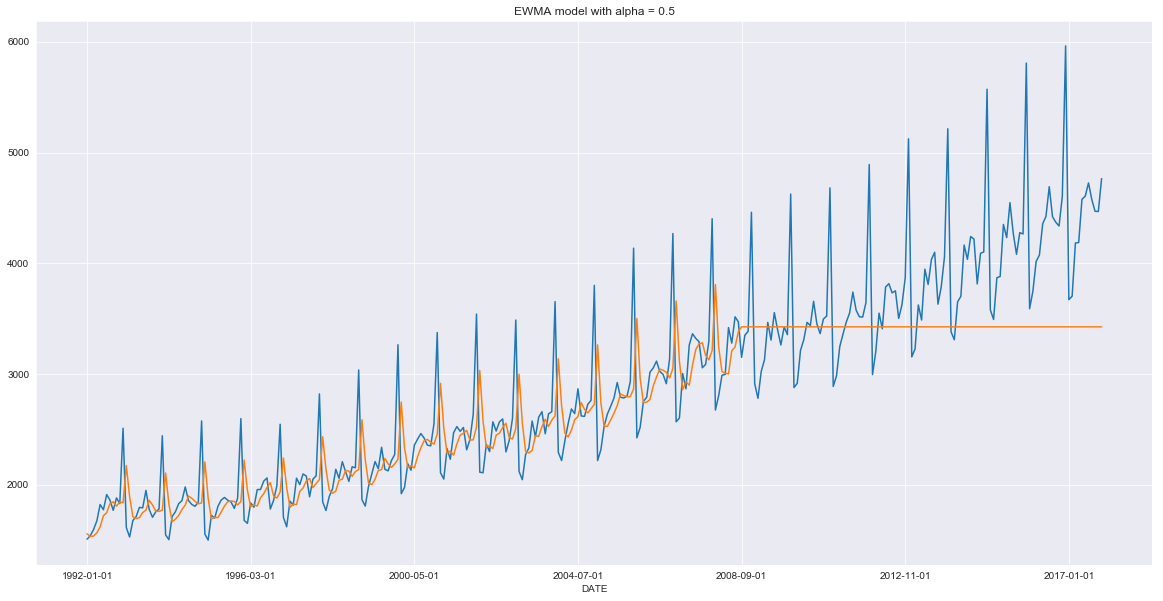

In [251]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
ax.set_title('EWMA model with alpha = 0.5')
_ = sb.lineplot(x=data.DATE, y=ts)
_ = sb.lineplot(x=data.DATE, y=preds)

In [252]:
# now let's find optimal alpha based on out of sample performance with target metric as MSE
scores = {}
alphas = np.arange(0.01, 0.99, 0.01)
for alpha in alphas:
    # compute averages
    ewma = ExponentialSmoothing(train_ts, trend=None, seasonal=None)
    ewma.fit(smoothing_level=alpha)
    
    # make predictions
    params = ewma.params
    preds = ewma.predict(params, 200, 310)
    
    # save mse score
    scores[alpha] = mse(test_ts, preds)
    

In [253]:
sorted_scores = sorted(scores.items(), key=lambda kv: kv[1])

print('Alpha | MSE')
for i, score in enumerate(sorted_scores):
    print('{:.2f}  | {:.2f}'.format(score[0], score[1]))
    if i > 4:
        break
        
best_alpha = sorted_scores[0][0]

Alpha | MSE
0.90  | 529143.08
0.91  | 529159.49
0.89  | 529160.72
0.92  | 529209.86
0.88  | 529212.61
0.93  | 529294.16


In [254]:
# optimal ewma model
ewma = ExponentialSmoothing(train_ts, trend=None, seasonal=None)
ewma.fit(smoothing_level=best_alpha)
params = ewma.params
ewma_preds = ewma.predict(params, 0, 310)
ewma_resids = test_ts - ewma_preds[200:]

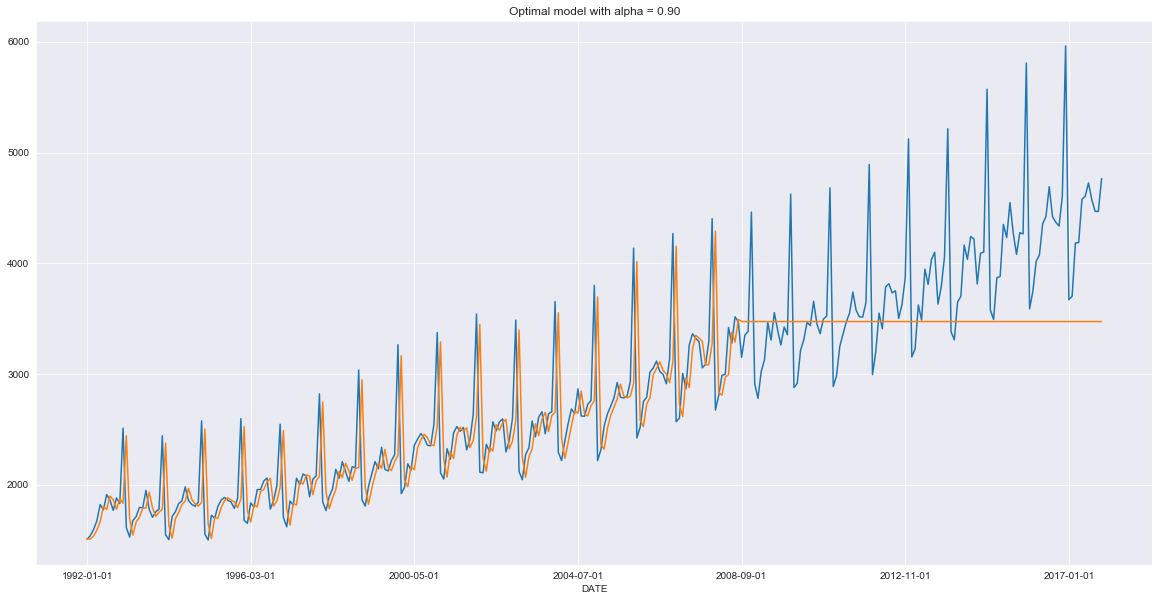

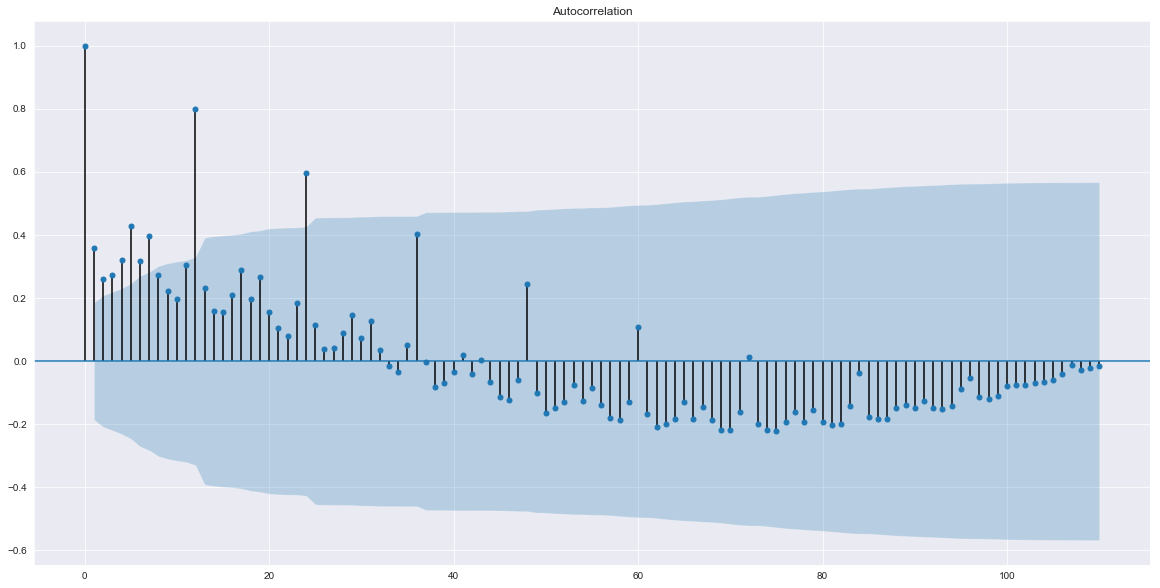

In [257]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
ax.set_title('Optimal model with alpha = {:.2f}'.format(best_alpha))
_ = sb.lineplot(x=data.DATE, y=ts)
_ = sb.lineplot(x=data.DATE, y=ewma_preds)

fig, ax = plt.subplots(figsize=(20, 10))
_ = plot_acf(ewma_resids, ax)

### Task 2. Holt

> <font size=3>
    We can see that such simple model is unable to capture even trend (it's clear from ACF - residuals have long memory), so let's introduce two new components - level and trend: <br><br>
    <center>${L}_{t} = \alpha Y_t + (1 - \alpha)(L_{t-1} + T_{t-1})$, where $\alpha \in (0, 1]$ </center><br>
    <center>${T}_{t} = \beta (L_t - L_{t-1}) + (1 - \beta)T_{t-1}$, where $\beta \in (0, 1]$ </center><br>
    Now we can forecast as follows:<br>
    <center>$\hat{Y}_{t+h} = L_t + hT_t$</center><br>
    Also, I need to mention that this is an additive form of Holt model and there exists multiplicative one. When we use additive method we express the component in absolute terms, but with multiplicative the component expressed relatively (in percentage). The choice depends on the nature of each component, if trend/seasonal component is roughly constant through time it's better to use additive method and multiplicative otherwise. The same is applicable to the Holt-Winters model, which we will use later.
  <font>

In [259]:
# let's find optimal alpha based on out of sample performance with target metric as MSE
scores = {}
alphas = np.arange(0.01, 0.99, 0.01)
betas = np.arange(0.01, 0.99, 0.01)
for alpha in tqdm(alphas):
    for beta in betas:
        # compute averages
        holt = ExponentialSmoothing(train_ts, trend='add', seasonal=None)
        holt.fit(smoothing_level=alpha, smoothing_slope=beta)

        # make predictions
        params = holt.params
        preds = holt.predict(params, 200, 310)

        # save mse score
        scores['{:.2f}, {:.2f}'.format(alpha, beta)] = mse(test_ts, preds)
        

In [260]:
sorted_scores = sorted(scores.items(), key=lambda kv: kv[1])

print('Alpha | Beta | MSE')
for i, score in enumerate(sorted_scores):
    print('{}  |{} | {:.2f}'.format(score[0].split(',')[0], score[0].split(',')[1], score[1]))
    if i > 4:
        break
        
best_alpha = float(sorted_scores[0][0].split(',')[0])
best_beta = float(sorted_scores[0][0].split(',')[1])

Alpha | Beta | MSE
0.02  | 0.13 | 227034.48
0.03  | 0.03 | 227090.90
0.05  | 0.83 | 227144.29
0.02  | 0.12 | 227304.24
0.06  | 0.69 | 227484.50
0.05  | 0.82 | 227949.61


In [261]:
# optimal Holt model
holt = ExponentialSmoothing(train_ts, trend='add', seasonal=None)
holt.fit(smoothing_level=best_alpha, smoothing_slope=best_beta)
params = holt.params
holt_preds = holt.predict(params, 0, 310)
holt_resids = test_ts - holt_preds[200:]

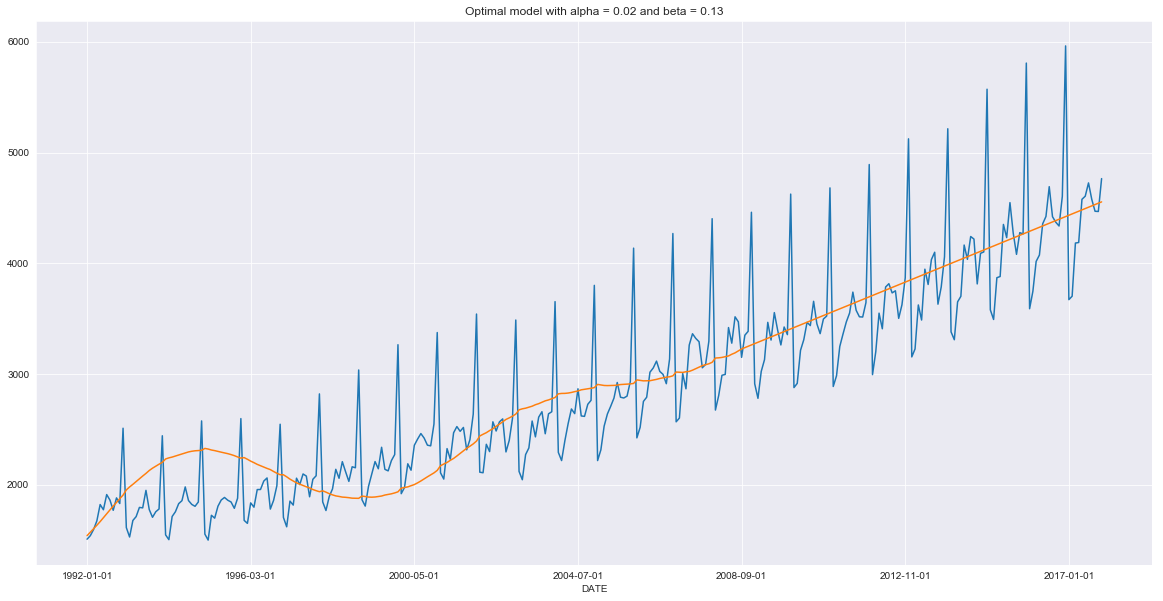

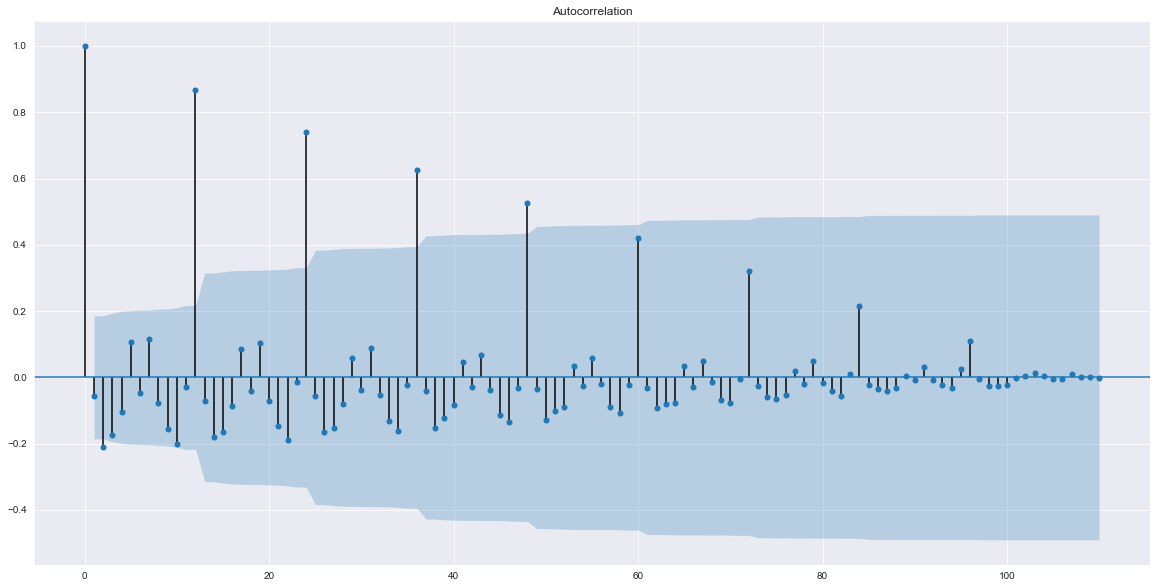

In [263]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
ax.set_title('Optimal model with alpha = {:.2f} and beta = {:.2f}'.format(best_alpha, best_beta))
_ = sb.lineplot(x=data.DATE, y=ts)
_ = sb.lineplot(x=data.DATE, y=holt_preds)

fig, ax = plt.subplots(figsize=(20, 10))
_ = plot_acf(holt_resids, ax)

### Task 3. Holt-Winters

> <font size=3>
    So now the forecast looks better, but such model fails to capture any seasonal information and as we can see from the ACF visualization there is a strong seasonal (with approx. 12 month period) signal in our time series, so let's try to incorporate this information: <br><br>
    <center>${L}_{t} = \alpha (Y_t - S_{t-s}) + (1 - \alpha)(L_{t-1} + T_{t-1})$, where $\alpha \in (0, 1]$ </center><br>
    <center>${T}_{t} = \beta (L_t - L_{t-1}) + (1 - \beta)T_{t-1}$, where $\beta \in (0, 1]$ </center><br>
    <center>${S}_{t} = \gamma (Y_t - L_{t}) + (1 - \gamma)S_{t-s}$, where $\gamma \in (0, 1]$ </center><br>
    And final forecast follows:<br>
    <center>$\hat{Y}_{t+h} = L_t + hT_t + S_{t-s+h}$</center>
  <font>

In [264]:
# let's find optimal alpha based on out of sample performance with target metric as MSE
scores = {}
alphas = np.arange(0.01, 0.99, 0.05)
betas = np.arange(0.01, 0.99, 0.05)
gammas = np.arange(0.01, 0.99, 0.05)
for alpha in tqdm(alphas):
    for beta in betas:
        for gamma in gammas:
            # compute averages
            hw = ExponentialSmoothing(train_ts, trend='add', seasonal='add', seasonal_periods=12)
            hw.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)

            # make predictions
            params = hw.params
            preds = hw.predict(params, 200, 310)

            # save mse score
            scores['{:.2f}, {:.2f}, {:.2f}'.format(alpha, beta, gamma)] = mse(test_ts, preds)
    

In [267]:
sorted_scores = sorted(scores.items(), key=lambda kv: kv[1])

print('Alpha |  Beta  | Gamma | MSE')
for i, score in enumerate(sorted_scores):
    print('{}  | {}  |{}  | {:.2f}'.format(score[0].split(',')[0], 
                                         score[0].split(',')[1], 
                                         score[0].split(',')[2],
                                         score[1]))
    if i > 4:
        break
        
best_alpha = float(sorted_scores[0][0].split(',')[0])
best_beta = float(sorted_scores[0][0].split(',')[1])
best_gamma = float(sorted_scores[0][0].split(',')[2])

Alpha |  Beta  | Gamma | MSE
0.11  |  0.71  | 0.56  | 16840.76
0.11  |  0.61  | 0.51  | 17065.76
0.01  |  0.11  | 0.61  | 17278.60
0.11  |  0.66  | 0.56  | 17348.42
0.01  |  0.11  | 0.56  | 17378.26
0.01  |  0.11  | 0.66  | 17585.76


In [268]:
# optimal Holt-Winters model
hw = ExponentialSmoothing(train_ts, trend='add', seasonal='add', seasonal_periods=12)
hw.fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
params = hw.params
hw_preds = hw.predict(params, 0, 310)
hw_resids = test_ts - hw_preds[200:]

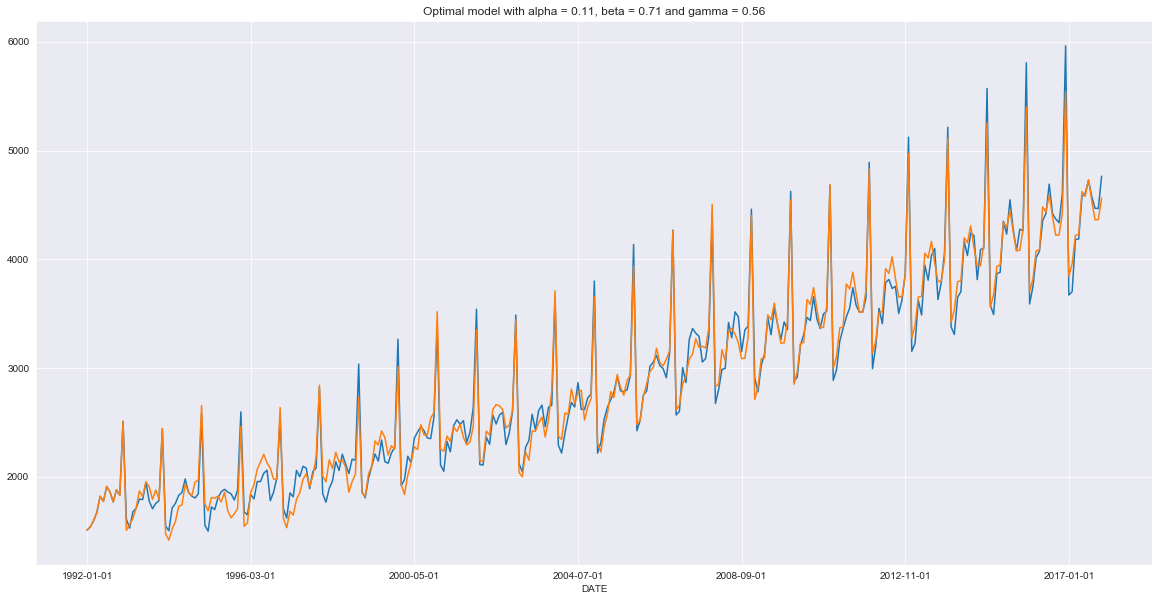

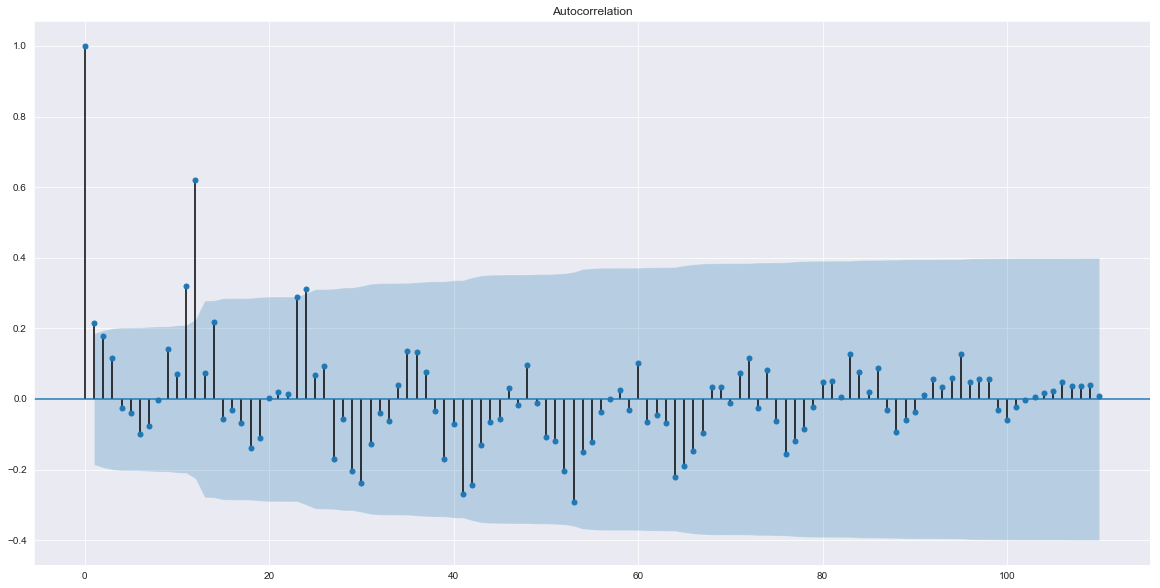

In [269]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
ax.set_title('Optimal model with alpha = {:.2f}, beta = {:.2f} and gamma = {:.2f}'.format(best_alpha, 
                                                                                          best_beta, 
                                                                                          best_gamma))
_ = sb.lineplot(x=data.DATE, y=ts)
_ = sb.lineplot(x=data.DATE, y=hw_preds)

fig, ax = plt.subplots(figsize=(20, 10))
_ = plot_acf(hw_resids, ax)

### Task 4. Tests

> <font size=3>
    The final model perfectly captures general information which exists in our time series and has good out of sample perfromance in terms of MSE. But let's look at different tests to check whether those models are statistically different. We'll perform three different tests (sign test, Wilcoxon sign rank test, Diebold-Mariano test) to check if the difference between errors from two different models differ.
  <font>

In [297]:
# sign test
from statsmodels.stats.descriptivestats import sign_test

sign_hw_vs_ewma = sign_test(np.power(hw_resids, 2) - np.power(ewma_resids, 2), 0)[1]
sign_hw_vs_ewma = 'reject' if sign_hw_vs_ewma < 0.05 else 'don\'t reject'

sign_hw_vs_holt = sign_test(np.power(hw_resids, 2) - np.power(holt_resids, 2), 0)[1]
sign_hw_vs_holt = 'reject' if sign_hw_vs_holt < 0.05 else 'don\'t reject'

sign_holt_vs_ewma = sign_test(np.power(hw_resids, 2) - np.power(holt_resids, 2), 0)[1]
sign_holt_vs_ewma = 'reject' if sign_holt_vs_ewma < 0.05 else 'don\'t reject'


In [298]:
# wilcoxon test
from scipy.stats import wilcoxon

wc_hw_vs_ewma = wilcoxon(np.power(hw_resids, 2) - np.power(ewma_resids, 2))[1]
wc_hw_vs_ewma = 'reject' if wc_hw_vs_ewma < 0.05 else 'don\'t reject'

wc_hw_vs_holt = wilcoxon(np.power(hw_resids, 2) - np.power(holt_resids, 2))[1]
wc_hw_vs_holt = 'reject' if wc_hw_vs_holt < 0.05 else 'don\'t reject'

wc_holt_vs_ewma = wilcoxon(np.power(hw_resids, 2) - np.power(holt_resids, 2))[1]
wc_holt_vs_ewma = 'reject' if wc_holt_vs_ewma < 0.05 else 'don\'t reject'


In [299]:
# Diebold-Mariano test
from scipy import stats

def dm_test(x):
    stat = np.mean(x) / np.sqrt(np.var(x, ddof=1))
    z_critical = stats.t.ppf(df=x.shape[0] - 1, q=1 - alpha/2)
    reject = 'reject' if stat < -z_critical or stat > z_critical else 'don''t reject'
    return reject

dm_hw_vs_ewma = dm_test(np.power(hw_resids, 2) - np.power(ewma_resids, 2))
dm_hw_vs_holt = dm_test(np.power(hw_resids, 2) - np.power(holt_resids, 2))
dm_holt_vs_ewma = dm_test(np.power(holt_resids, 2) - np.power(ewma_resids, 2))

In [309]:
print('Tests results:')
print('Pair                 | Sign   | Wilcoxon | Diebold-Mariano ')
print('Holt == EWMA         | {} | {}   | {}'.format(sign_holt_vs_ewma, wc_holt_vs_ewma, dm_holt_vs_ewma))
print('Holt-Winters == EWMA | {} | {}   | {}'.format(sign_hw_vs_ewma, wc_hw_vs_ewma, dm_hw_vs_ewma))
print('Holt-Winters == Holt | {} | {}   | {}'.format(sign_hw_vs_holt, wc_hw_vs_holt, dm_hw_vs_holt))

Tests results:
Pair                 | Sign   | Wilcoxon | Diebold-Mariano 
Holt == EWMA         | reject | reject   | reject
Holt-Winters == EWMA | reject | reject   | reject
Holt-Winters == Holt | reject | reject   | reject


> <font size=3>
    All three tests suggest that we can't reject the hypothesis that the performances of all three models differ.
  <font>

### Part 4. ARIMA

In [645]:
data = pd.read_csv('./interestrate.csv', header=None, sep=';')
data.head()

,0,1,2
0,2003-01,"2,50",NaN
1,2003-02,"1,95",NaN
2,2003-03,"1,87",NaN
3,2003-04,"2,07",NaN
4,2003-05,"2,31",NaN


In [646]:
data = data.rename(columns={0: 'date', 1: 'ts'})
data = data.drop(columns=[2])
data.ts = data.ts.apply(lambda x: float(x.replace(',', '.')))
data.head()

,date,ts
0,2003-01,2.50
1,2003-02,1.95
2,2003-03,1.87
3,2003-04,2.07
4,2003-05,2.31


### Task 1. ACF

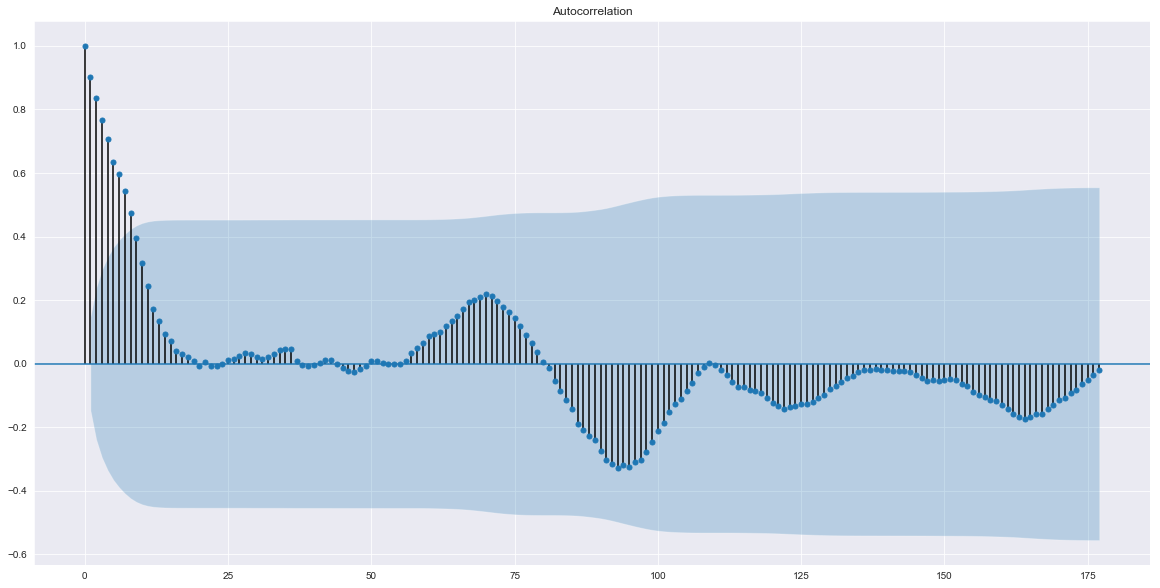

In [629]:
fig, ax = plt.subplots(figsize=(20, 10))
_ = plot_acf(data.ts, ax)

In [630]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung = acorr_ljungbox(data.ts.values, boxpierce=False, lags=20)[1][-1]
ljung = 'can reject' if ljung < 0.05 else 'can''t reject'

pierce = acorr_ljungbox(data.ts.values, boxpierce=True, lags=20)[3][-1]
pierce = 'can reject' if pierce < 0.05 else 'can''t reject'

print('Based on Ljung test (for lag 20) we {} the hypothesis that process isn\'t autocorrelated'.format(ljung))
print('Based on Pierce test (for lag 20) we {} the hypothesis that process isn\'t autocorrelated'.format(pierce))

Based on Ljung test (for lag 20) we can reject the hypothesis that process isn't autocorrelated
Based on Pierce test (for lag 20) we can reject the hypothesis that process isn't autocorrelated


### Basic ARMA models

In [647]:
train_data, test_data = data[data.date < '2017-01'], data[data.date >= '2017-01']

In-sample AIC: 287.93
Out-of-sample MSE: 3.62


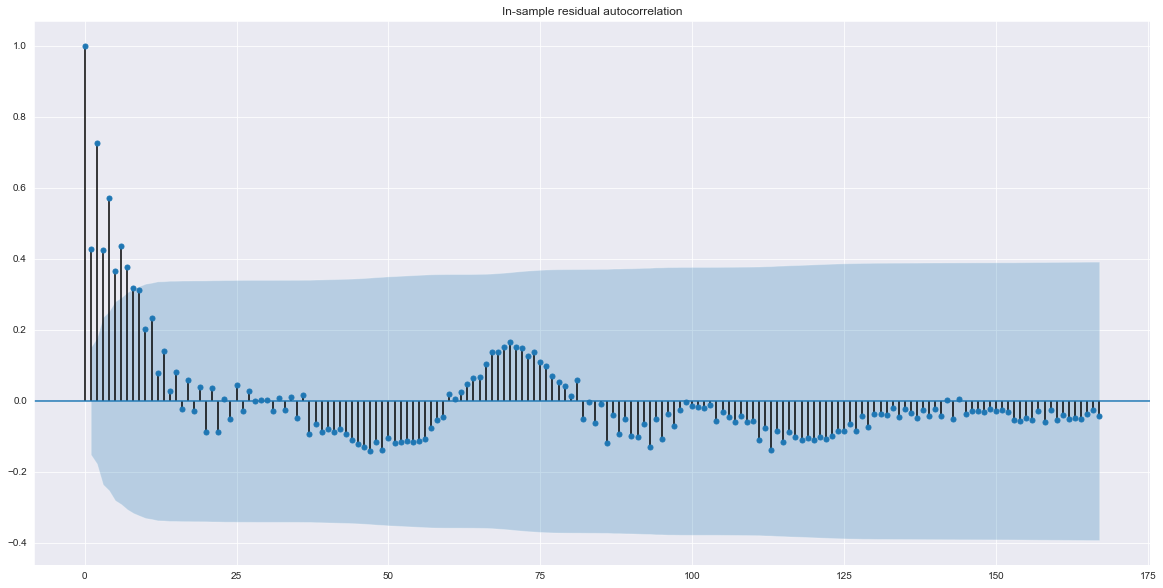

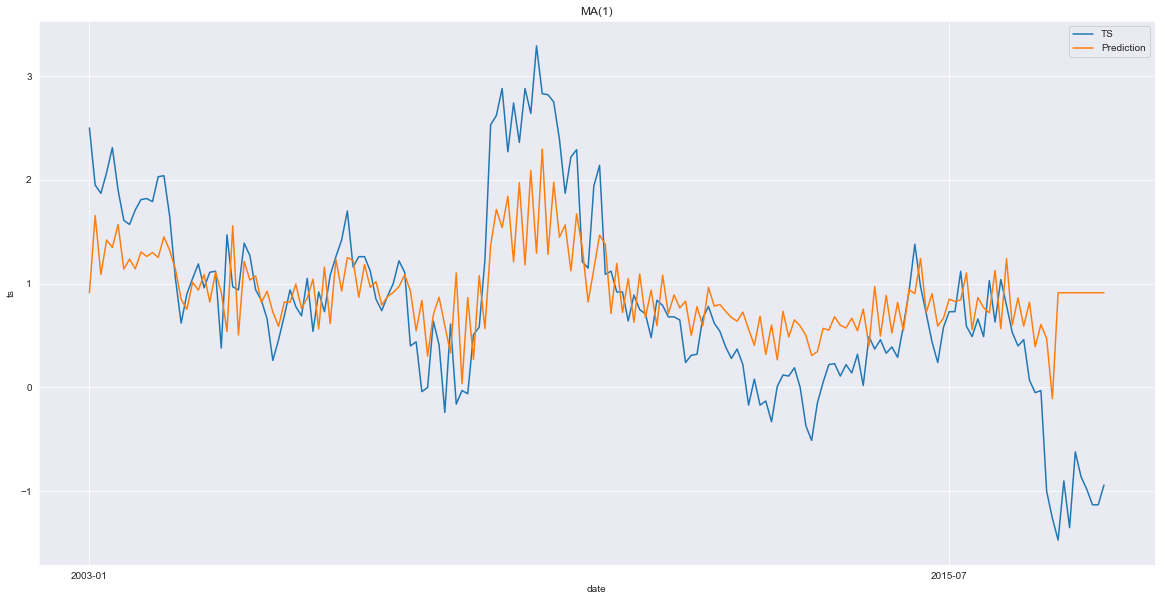

In [640]:
# MA(1) model

order = (0, 1)
ma = ARMA(train_data.ts, order, dates=train_data.date).fit()

preds = ma.predict(start='2017-01-01', end='2017-10-01')
resids = ma.resid.values
score = mse(test_data.ts.values, preds.values)

print('In-sample AIC: {:.2f}'.format(ma.aic))
print('Out-of-sample MSE: {:.2f}'.format(score))

fig, ax = plt.subplots(figsize=(20, 10))
_ = plot_acf(resids, ax, title='In-sample residual autocorrelation')

preds = ma.predict(start='2003-01-01', end='2017-10-01')
fig, ax = plt.subplots(figsize=(20, 10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=150))
ax.set_title('MA(1)')
_ = sb.lineplot(x=data.date, y=data.ts, label='TS')
_ = sb.lineplot(x=data.date, y=preds.values, label='Prediction')
_ = plt.legend()


In-sample AIC: 135.97
Out-of-sample MSE: 0.64


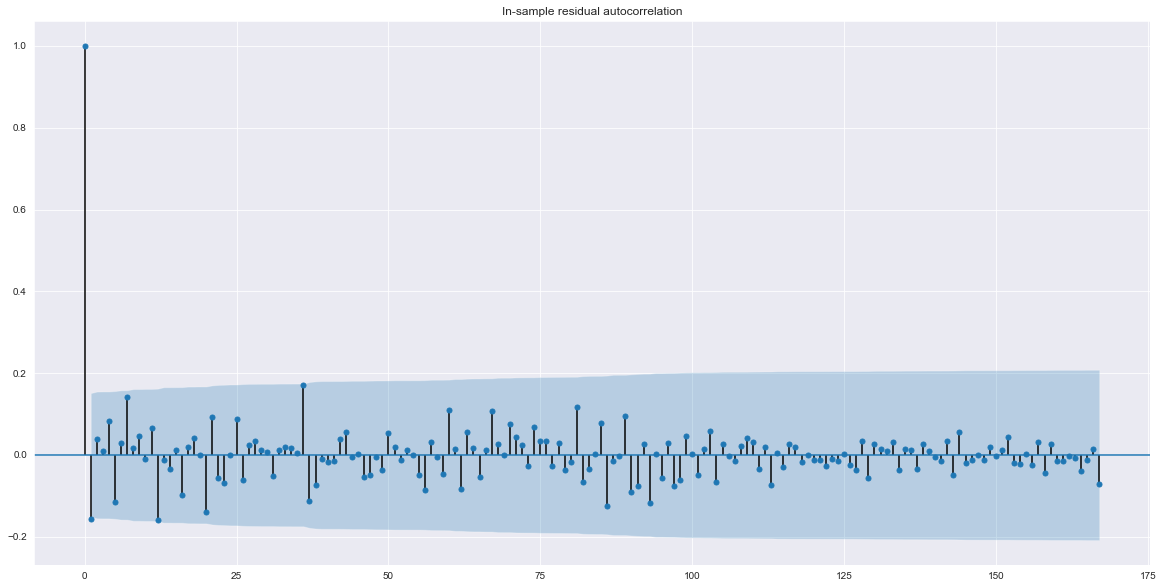

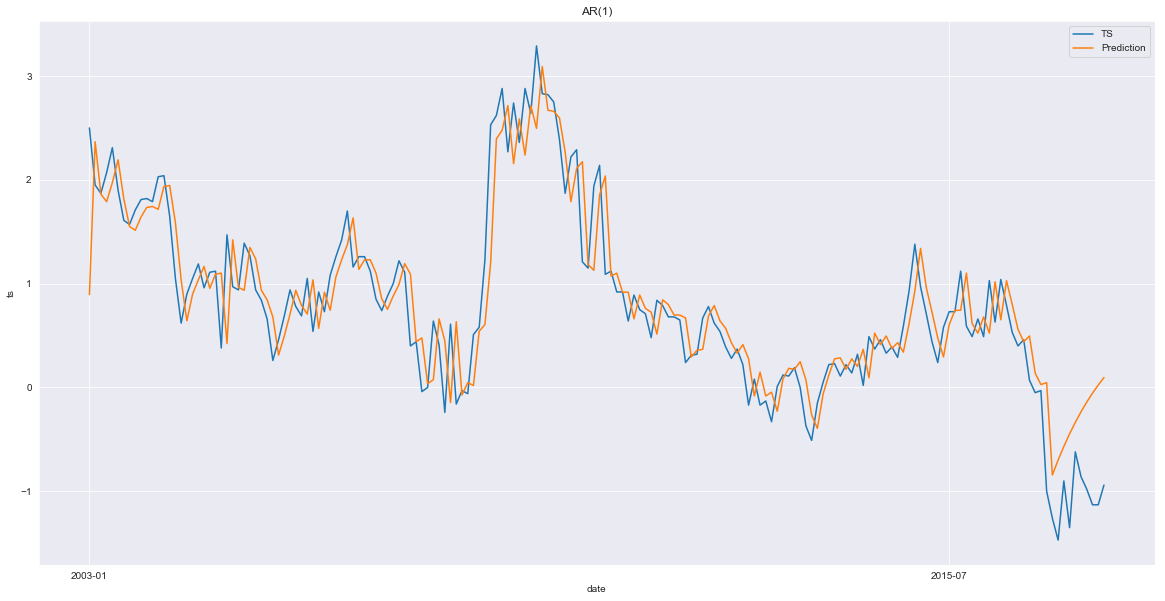

In [641]:
# AR(1) model

order = (1, 0)
ma = ARMA(train_data.ts, order, dates=train_data.date).fit()

preds = ma.predict(start='2017-01-01', end='2017-10-01')
resids = ma.resid.values
score = mse(test_data.ts.values, preds.values)

print('In-sample AIC: {:.2f}'.format(ma.aic))
print('Out-of-sample MSE: {:.2f}'.format(score))

fig, ax = plt.subplots(figsize=(20, 10))
_ = plot_acf(resids, ax, title='In-sample residual autocorrelation')

preds = ma.predict(start='2003-01-01', end='2017-10-01')
fig, ax = plt.subplots(figsize=(20, 10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=150))
ax.set_title('AR(1)')
_ = sb.lineplot(x=data.date, y=data.ts, label='TS')
_ = sb.lineplot(x=data.date, y=preds.values, label='Prediction')
_ = plt.legend()


In-sample AIC: 134.27
Out-of-sample MSE: 0.53


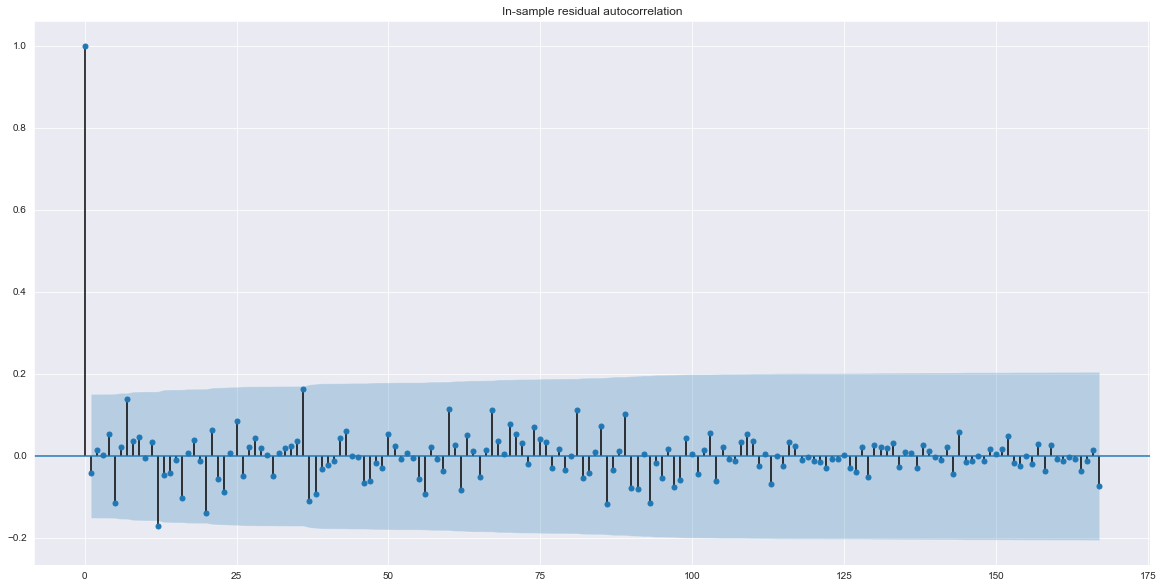

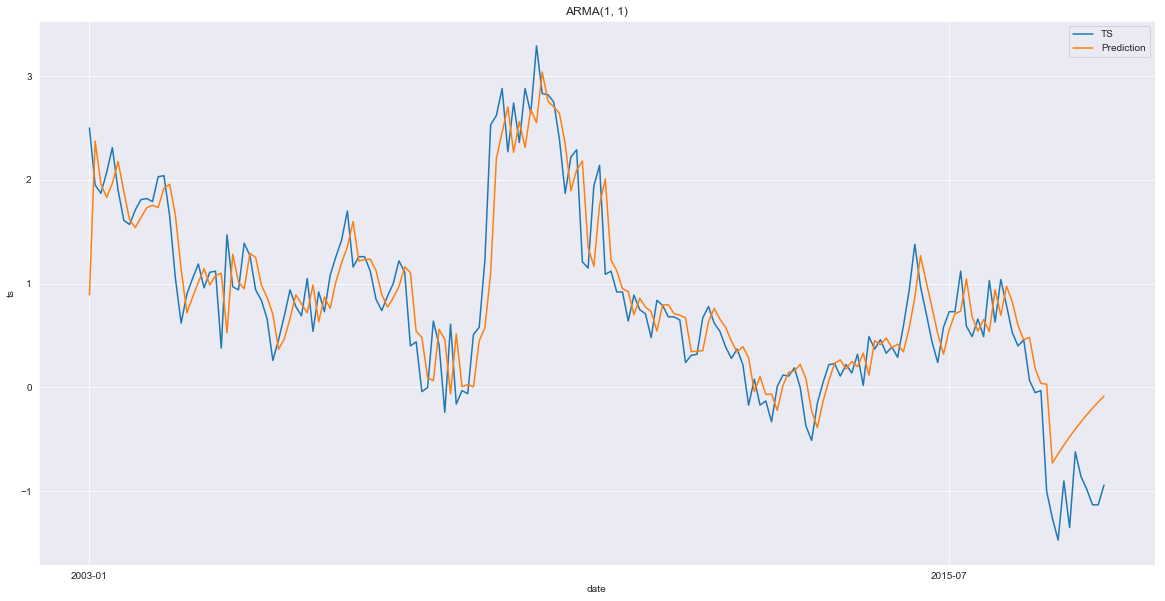

In [642]:
# ARMA(1, 1) model

order = (1, 1)
ma = ARMA(train_data.ts, order, dates=train_data.date).fit()

preds = ma.predict(start='2017-01-01', end='2017-10-01')
resids = ma.resid.values
score = mse(test_data.ts.values, preds.values)

print('In-sample AIC: {:.2f}'.format(ma.aic))
print('Out-of-sample MSE: {:.2f}'.format(score))

fig, ax = plt.subplots(figsize=(20, 10))
_ = plot_acf(resids, ax, title='In-sample residual autocorrelation')

preds = ma.predict(start='2003-01-01', end='2017-10-01')
fig, ax = plt.subplots(figsize=(20, 10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=150))
ax.set_title('ARMA(1, 1)')
_ = sb.lineplot(x=data.date, y=data.ts, label='TS')
_ = sb.lineplot(x=data.date, y=preds.values, label='Prediction')
_ = plt.legend()


### Series of the differnces

In-sample AIC for model with order (1, 0): 172.88
Out-of-sample MSE: 0.14
In-sample AIC for model with order (0, 1): 172.67
Out-of-sample MSE: 0.15
In-sample AIC for model with order (1, 1): 174.61
Out-of-sample MSE: 0.15


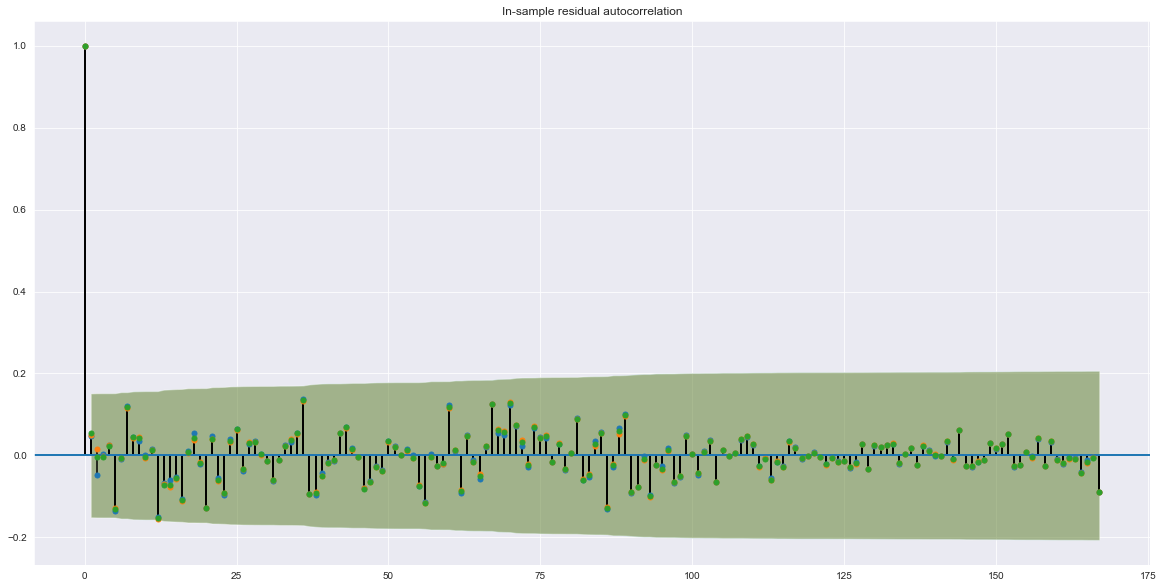

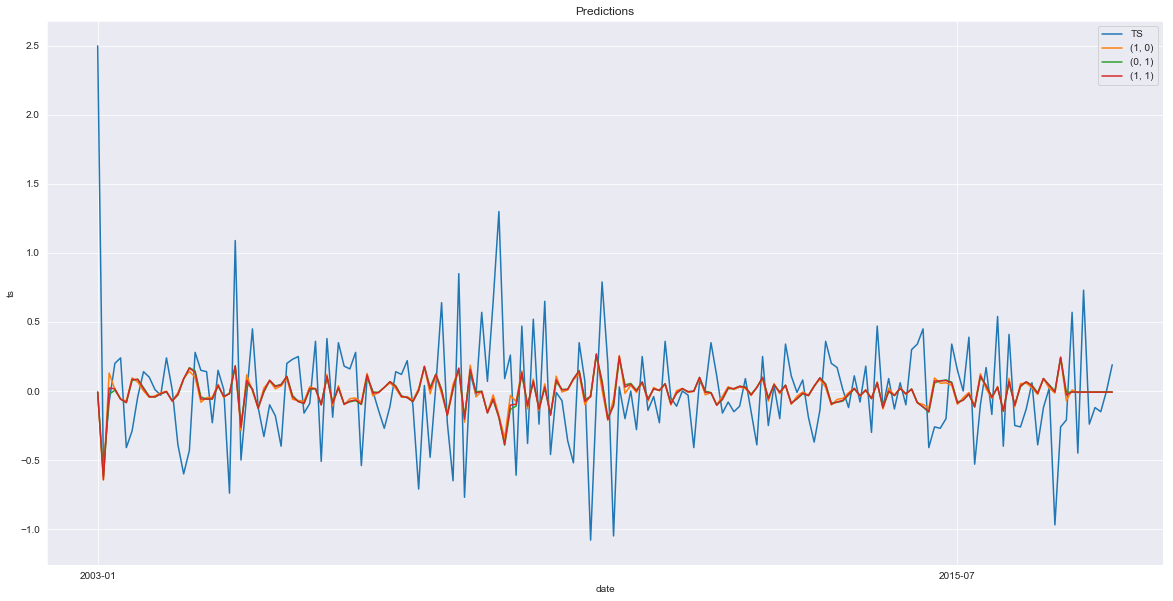

In [644]:
fig1, ax1 = plt.subplots(figsize=(20, 10))
fig2, ax2 = plt.subplots(figsize=(20, 10))

data.ts.iloc[1:] = data.ts.diff()[~data.ts.diff().isnull()]
train_data, test_data = data[data.date < '2017-01'], data[data.date >= '2017-01']

ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=150))
ax2.set_title('Predictions')
_ = sb.lineplot(x=data.date, y=data.ts, label='TS', ax=ax2)

orders = [(1, 0), (0, 1), (1, 1)]
for order in orders:
    ma = ARMA(train_data.ts, order, dates=train_data.date).fit()

    preds = ma.predict(start='2017-01-01', end='2017-10-01')
    resids = ma.resid.values
    score = mse(test_data.ts.values, preds.values)

    print('In-sample AIC for model with order {}: {:.2f}'.format(order, ma.aic))
    print('Out-of-sample MSE: {:.2f}'.format(score))

    _ = plot_acf(resids, ax1, title='In-sample residual autocorrelation')

    preds = ma.predict(start='2003-01-01', end='2017-10-01')
    _ = sb.lineplot(x=data.date, y=preds.values, label=str(order), ax=ax2)
    _ = ax.legend()


> <font size=3>
    From my perspective the best method to check model performance is to make cross-validation, so based on out-of-sample MSE score I can suggest that AR(1) model is slightly better that AR(1) or ARMA(1,1).
  <font>

### Task 4. Autoarima

In [658]:
stepwise_fit = auto_arima(train_data.ts.values, 
                          start_p=1, start_q=1, start_d=0,
                          max_p=5, max_q=5, max_d=5,
                          start_P=0, seasonal=False, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True,  
                          stepwise=True)

Fit ARIMA: order=(1, 1, 1); AIC=134.163, BIC=146.635, Fit time=0.114 seconds
Fit ARIMA: order=(0, 1, 0); AIC=136.339, BIC=142.575, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=132.304, BIC=141.658, Fit time=0.022 seconds
Fit ARIMA: order=(0, 1, 1); AIC=132.163, BIC=141.517, Fit time=0.024 seconds
Fit ARIMA: order=(0, 1, 2); AIC=134.163, BIC=146.635, Fit time=0.040 seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.229 seconds


In [659]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  167
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -63.082
Method:                       css-mle   S.D. of innovations              0.353
Date:                Mon, 11 Feb 2019   AIC                            132.163
Time:                        00:42:28   BIC                            141.517
Sample:                             1   HQIC                           135.960
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0192      0.022     -0.875      0.383      -0.062       0.024
ma.L1.D.y     -0.1991      0.078     -2.539      0.012      -0.353      -0.045
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            5.0223           +0.0000j            5.0223            0.0000
-----------------------------------------------------------------------------
"""

In [660]:
print('Out-of-sample mse score: {:.6f}'.format(mse(test_data.ts.values, stepwise_fit.predict(n_periods=test_data.ts.shape[0]))))
print('Previous model ARMA(1, 1) out-of-sample mse score is: {:.2f}'.format(0.14))


Out-of-sample mse score: 0.092559
Previous model ARMA(1, 1) out-of-sample mse score is: 0.14


> <font size=3>
    Based on out-of-sample performance I can suggest the the model found by autoarima ARIMA(0,1,1) is better than basic AR(1).
  <font>

### Task 5. Forecast intervals 

In [671]:
preds, conf_intervals = stepwise_fit.predict(n_periods=test_data.shape[0], return_conf_int=True)

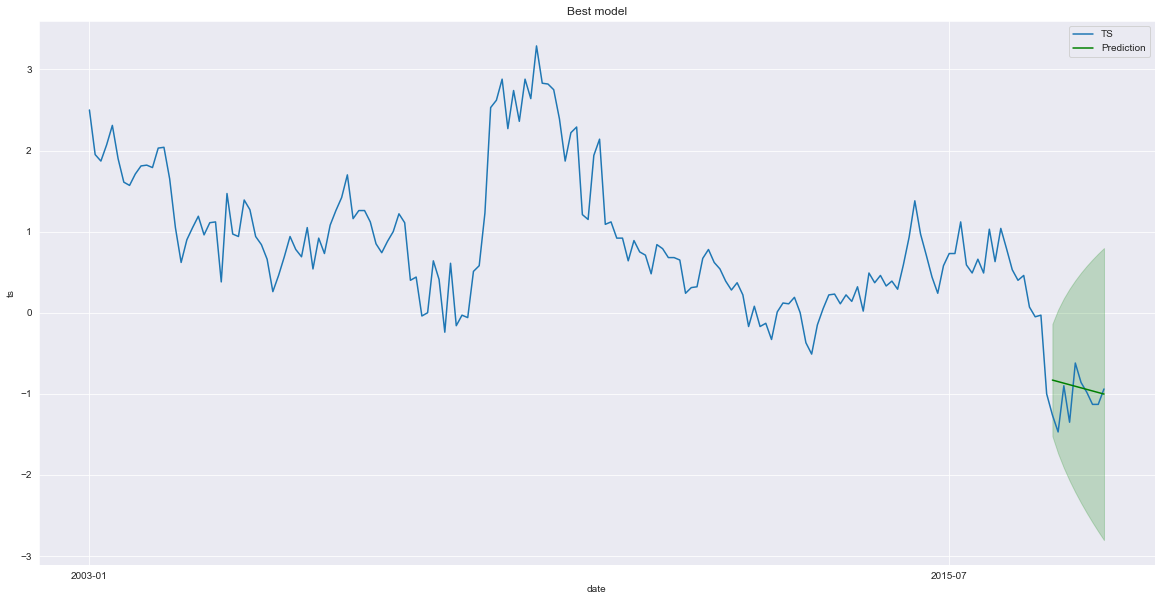

In [679]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=150))
ax.set_title('Best model')
_ = sb.lineplot(x=data.date, y=data.ts, label='TS')
_ = sb.lineplot(x=test_data.date, y=preds[:], label='Prediction', color='green')
ax.fill_between(x=test_data.date, y1=conf_intervals[:, 0], y2=conf_intervals[:, 1], alpha=0.2, color='green')
_ = plt.legend()

### Q&A

> **Q**: Why multi-step-ahead forecasts have wider forecast intervals than onestep-ahead-forecasts?

> **A**: Intuitively as multi-step forecast is a series of onestep forecasts uncertainty accumulates with each step. 

> **Q** : Imagine an ACF with only the first two correlations being significant. Which
process is suitable to model this and why?

> **A**: We know that for MA(q) process autocovariance function $\gamma_h = 0$ if $h > q$, so with MA(2) process we can easily model this time series. 

> **Q**: Imagine an ACF which consists only of positive values and quickly decays towards
zero. Which process is suitable to model this and why?

> **A**: We can write down Yule-Walker equation for AR(p) process $\gamma_h = \sum \limits_{v=1}^{p} \alpha_v \gamma_{h-v}$, so we can say that AP(1) process with small coefficient ($\alpha_1 \approx 0$) is the most suitable model.

> **Q**: Consider an AR(1) process with parameter $\alpha_1$. Assume we have a shock to a time
series (a large error term, unexpected event) at the time point t = 10. Which
impact do you expect this shock to have on the observation at time point t = 15?
Provide the formula and give formal motivation.

> **A**: Let $x_t$ follow AR(1) process, then $x_t$ = $\alpha x_{t-1} + \epsilon_{t}$. Now let's introduce new process $y_t = x_t$ if $t \neq \tau$ and $y_t = x_t + \beta d_t$ if $t=\tau$, where $\beta$ is some shock and $d_t$ shows direction of the shock value (positive or negative). Then we can write down $y_{t+h}$ as follows:<br><br>
    <center>$y_{t} = \alpha y_{t-1} + \epsilon_t + \beta d_t = x_t + \beta$</center>
    <center>$y_{t+1} = x_{t+1} + \alpha \beta$</center>
    <center>$y_{t+h} = x_{t+h} + \alpha^h \beta$</center>

### Part 5. GARCH

In [706]:
data = pd.read_csv('./CrudeOil.csv')
data = data.rename(columns={'DATE': 'date', 'DCOILBRENTEU': 'ts'})
data.ts = data.ts.fillna(data.ts.mean())
data.ts.iloc[1:] = data.ts.rolling(window=2).apply(lambda x: np.log(x[1] / x[0])).dropna()
data = data.iloc[1:]
data.head()

,date,ts
1,2009-01-07,-0.055944
2,2009-01-08,-0.073825
3,2009-01-09,-0.014072
4,2009-01-12,-0.035581
5,2009-01-13,0.052211


### Task 1. Insights from ACF

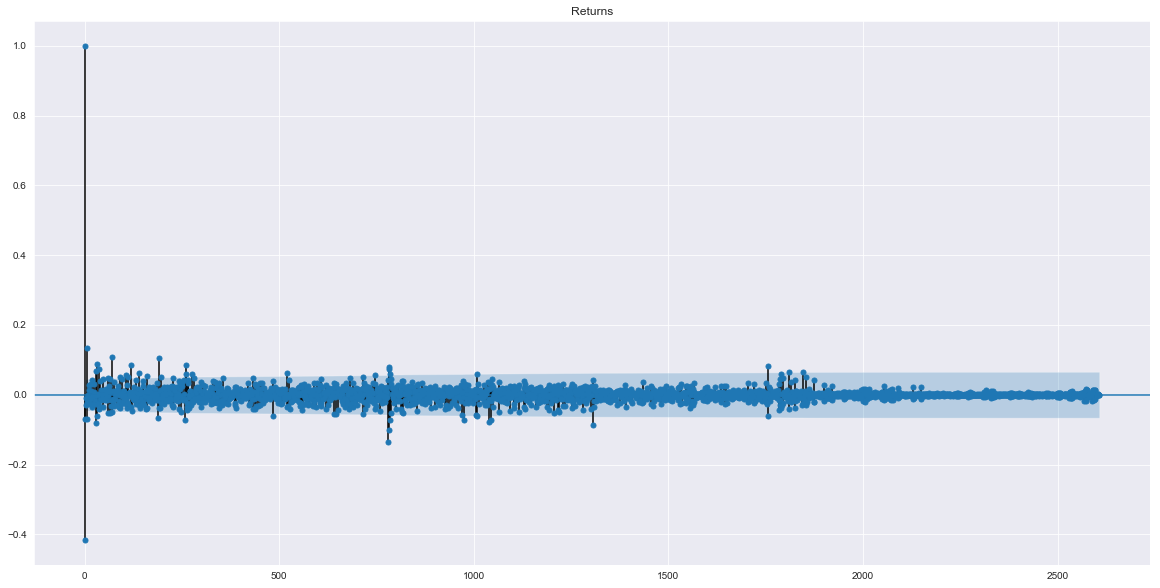

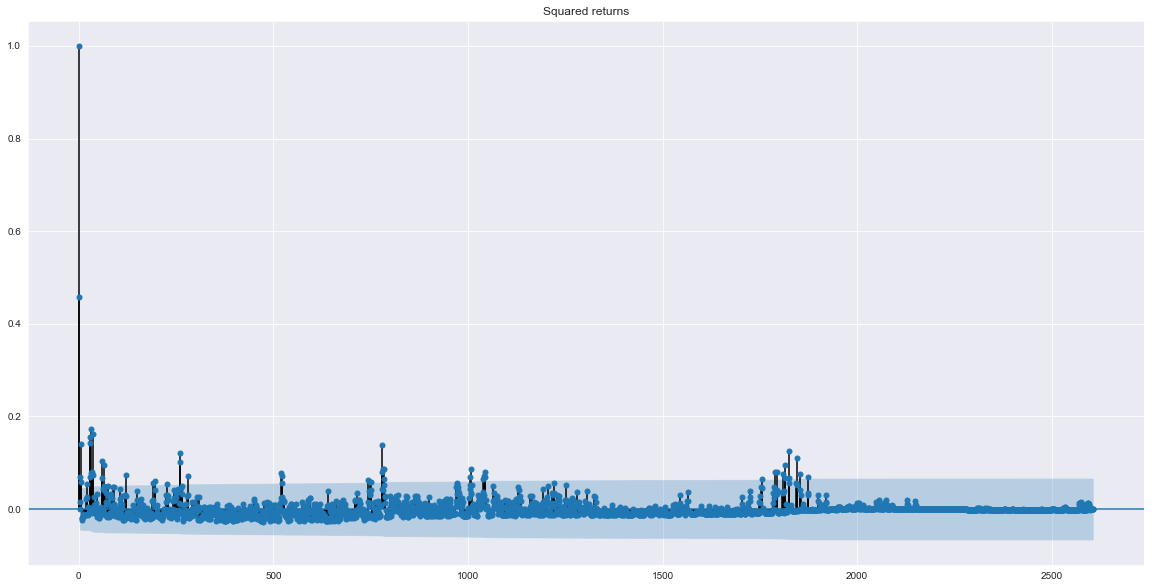

In [707]:
fig, ax = plt.subplots(figsize=(20, 10))
_ = plot_acf(data.ts, ax, title='Returns')
fig, ax = plt.subplots(figsize=(20, 10))
_ = plot_acf(np.power(data.ts, 2), ax, title='Squared returns')

> <font size=3>
    We see that there is no strong correlation in returns, but there is some useful signal in squared returns. 
  <font>

### ARCH, GARCH and conditional volatilities

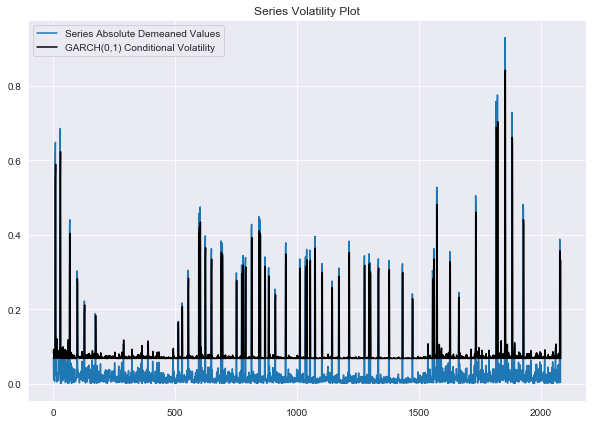

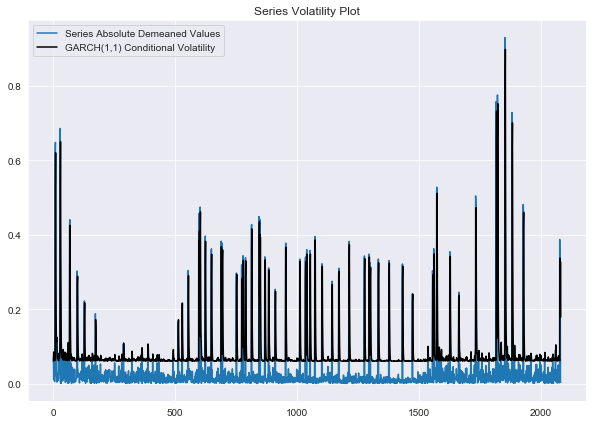

In [708]:
arch = pf.GARCH(train_data.ts.values, 0, 1)
garch = pf.GARCH(train_data.ts.values, 1, 1)
arch.fit()
garch.fit()

_ = arch.plot_fit(ax=ax)
_ = garch.plot_fit(ax=ax)

In [709]:
arch.fit().summary()

GARCH(0,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 1                                           Log Likelihood: 2421.4774                         
End Date: 2082                                          AIC: -4836.9548                                   
Number of observations: 2082                            BIC: -4820.0315                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0045                                                           
q(1)                                 

In [710]:
garch.fit().summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 1                                           Log Likelihood: 2491.6019                         
End Date: 2082                                          AIC: -4975.2037                                   
Number of observations: 2082                            BIC: -4952.6394                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0026                                                           
q(1)                                 

> <font size=3>
    Based on BIC I can say that GARCH(1,1) model is better that ARCH(1). But let's check autocorrelation of the residuals (by Ljung test) and perform test about the equality of those models (e.g., Wilcoxon).
  <font>

In [711]:
def compute_residuals(model):
    
    sigma_squared, Y, _ = model._model(model.latent_variables.get_z_values())
    demeaned_Y = Y - model.transform_z()[-1]
    
    return demeaned_Y**2 / sigma_squared

In [725]:
arch_resids = compute_residuals(arch)
garch_resids = compute_residuals(garch)

wc = wilcoxon(np.power(arch_resids, 2) - np.power(garch_resids, 2))[1]
wc = 'can reject' if wc < 0.05 else 'can\'t reject'

arch_ljung = acorr_ljungbox(arch_resids, boxpierce=False, lags=20)[1][-1]
arch_ljung = 'can reject' if arch_ljung < 0.05 else 'can\'t reject'

garch_ljung = acorr_ljungbox(garch_resids, boxpierce=False, lags=20)[1][-1]
garch_ljung = 'can reject' if garch_ljung < 0.05 else 'can\'t reject'


print('We {} the hypothesis that residuals of both model are equal, ' \
      'we {} the hypothesis that ARCH residuals aren\'t autocorrelated and ' \
      'we {} the hypothesis that GARCH residuals aren\'t autocorrelated'.format(wc, arch_ljung, garch_ljung))

We can reject the hypothesis that residuals of both model are equal, we can reject the hypothesis that ARCH residuals aren't autocorrelated and we can't reject the hypothesis that GARCH residuals aren't autocorrelated


> <font size=3>
    So we see that there is some statistical difference in the results of both model (based on Wilcoxon test). Also, we can't reject the hypothesis that residuals aren't autocorrelated for GARCH model, which means that this model extracted more information from the signal than ARCH model (if there is some autocorrelation between residuals it means that there is some useful signal, which our model is unable to extract).
  <font>

### Q&A

> **Q**: Explain in your own words the difference between conditional and unconditional
volatility

> **A**: Conditional volatility is conditioned on its past values and model error, it varies through time and describes underline volatility at certian time point. Unconditional volatility is the general volatility of the process.

> **Q**: Explain in your own words idea behind the news curve.

> **A**: NIC helps us to measure the impact of a shock in the current time point on the conditional volatility in the next time point. For example, from lectures we know that for ARCH(1) process $NIC(\epsilon) = \alpha_1 \epsilon^2 \sigma^2$, this function shows the difference between future volatility with the shock in the current period and without.
